In [27]:
%pylab inline
import pandas as pd
import pickle
import os
from datetime import date
from sklearn.preprocessing import MinMaxScaler

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('parsed/trans.csv')
print(df.head())

   trans_id  account_id    date    type operation  amount  balance k_symbol  \
0    695247        2378  930101  PRIJEM     VKLAD   700.0    700.0      NaN   
1    171812         576  930101  PRIJEM     VKLAD   900.0    900.0      NaN   
2    207264         704  930101  PRIJEM     VKLAD  1000.0   1000.0      NaN   
3   1117247        3818  930101  PRIJEM     VKLAD   600.0    600.0      NaN   
4    579373        1972  930102  PRIJEM     VKLAD   400.0    400.0      NaN   

  bank  account  
0  NaN      NaN  
1  NaN      NaN  
2  NaN      NaN  
3  NaN      NaN  
4  NaN      NaN  


/home/ing-luca/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
min_date = df['date'].min()
max_date = df['date'].max()
print(min_date, max_date)

930101 981231


## Positive and negative transactions only

In [4]:
df_tc = df.groupby('account_id', as_index=False).size().rename('transaction_count').reset_index()
account_id_list = df_tc['account_id'].tolist()

In [5]:
def split_date(input_date):
    year = 1900 + int(str(input_date)[0:2])
    month = int(str(input_date)[2:4])
    day = int(str(input_date)[4:6])
    return year, month, day

def date_to_index(input_date, starting_date=min_date):
    input_year, input_month, input_day = split_date(input_date)
    starting_year, starting_month, starting_day = split_date(starting_date)

#     delta = date(input_year, input_month, input_day) - date(starting_year, starting_month, starting_day)
    delta = date(input_year, input_month, input_day) - date(1993, 1, 1)
    return delta.days

In [6]:
total_days = 2190
transactions = np.zeros((len(account_id_list), total_days), dtype=np.float32)
transactions.shape

(4500, 2190)

In [7]:
for account_index, account_id in enumerate(account_id_list):
    if account_index % 100 == 0:
        print(account_index, '/', len(account_id_list))
        
    df_account = df.query('account_id == ' + str(account_id))
    for _, row in df_account.iterrows():
        transaction_date = row['date']
        amount = row['amount']
        if row['type'] == 'VYDAJ':
            amount = -amount
        try:
            transactions[account_index, date_to_index(transaction_date)] = amount
        except:
            pass
print(len(account_id_list), '/', len(account_id_list))

0 / 4500
100 / 4500
200 / 4500
300 / 4500
400 / 4500
500 / 4500
600 / 4500
700 / 4500
800 / 4500
900 / 4500
1000 / 4500
1100 / 4500
1200 / 4500
1300 / 4500
1400 / 4500
1500 / 4500
1600 / 4500
1700 / 4500
1800 / 4500
1900 / 4500
2000 / 4500
2100 / 4500
2200 / 4500
2300 / 4500
2400 / 4500
2500 / 4500
2600 / 4500
2700 / 4500
2800 / 4500
2900 / 4500
3000 / 4500
3100 / 4500
3200 / 4500
3300 / 4500
3400 / 4500
3500 / 4500
3600 / 4500
3700 / 4500
3800 / 4500
3900 / 4500
4000 / 4500
4100 / 4500
4200 / 4500
4300 / 4500
4400 / 4500
4500 / 4500


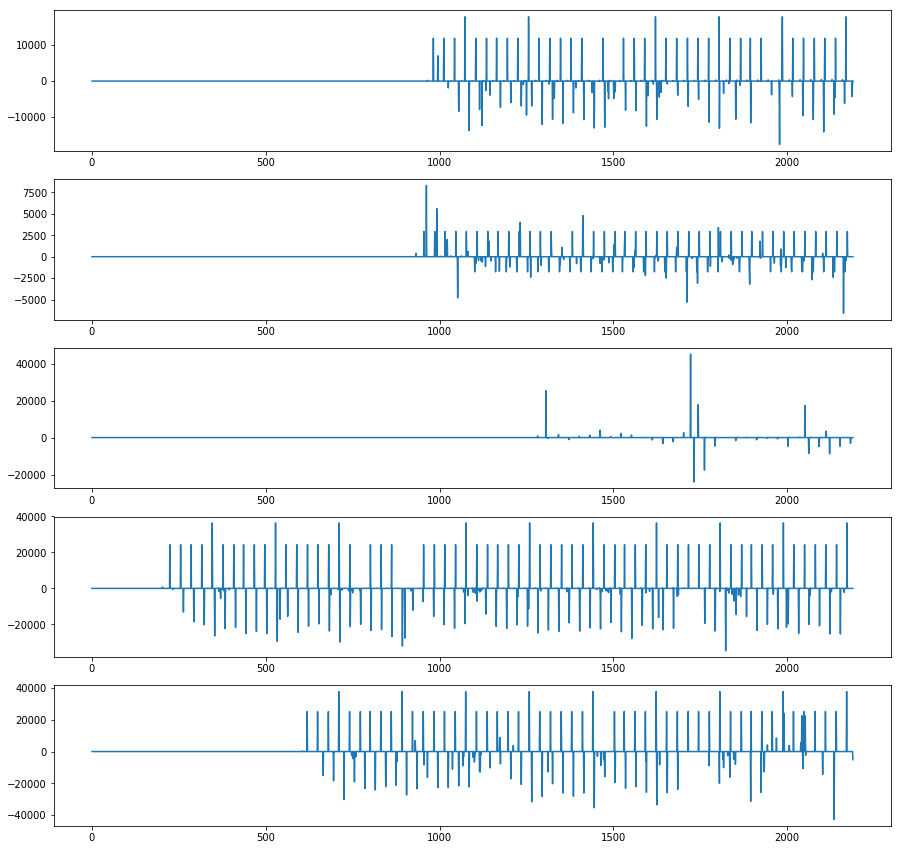

In [8]:
samples = 5
indexes = np.random.choice(len(account_id_list), samples)
plt.subplots(samples, 1, figsize=(15, 3*samples))

for i, index in enumerate(indexes):
    plt.subplot(samples, 1, i+1)
    plt.plot(transactions[index])
plt.show()

In [11]:
np.save('usable/transactions.npy', transactions)

## Normalized transactions (without outliers)

In [12]:
transactions = np.load('usable/transactions.npy')

In [13]:
percentile_1 = np.percentile(transactions, 1)
percentile_99 = np.percentile(transactions, 99)
transactions[transactions < percentile_1] = percentile_1
transactions[transactions > percentile_99] = percentile_99

transactions_min = np.min(transactions)
transactions_max = np.max(transactions)
transactions = 2 * ((transactions - transactions_min) / (transactions_max - transactions_min)) - 1

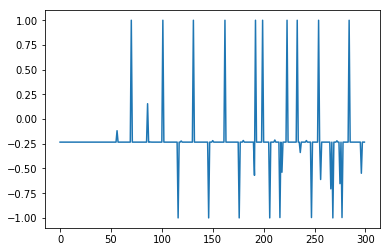

In [14]:
plt.plot(transactions[1, :][:300])

In [15]:
np.save('usable/normalized_transactions.npy', transactions)

## Amounts and balances

In [16]:
transactions = np.load('usable/transactions.npy')
transactions.shape

(4500, 2190)

In [17]:
transactions = np.dstack([transactions, np.zeros((transactions.shape))])

for i in range(transactions.shape[0]):
    past_balance = 0
    for j in range(transactions.shape[1]):
        if transactions[i, j, 0] != 0:
            past_balance += transactions[i, j, 0]
        transactions[i, j, 1] = past_balance

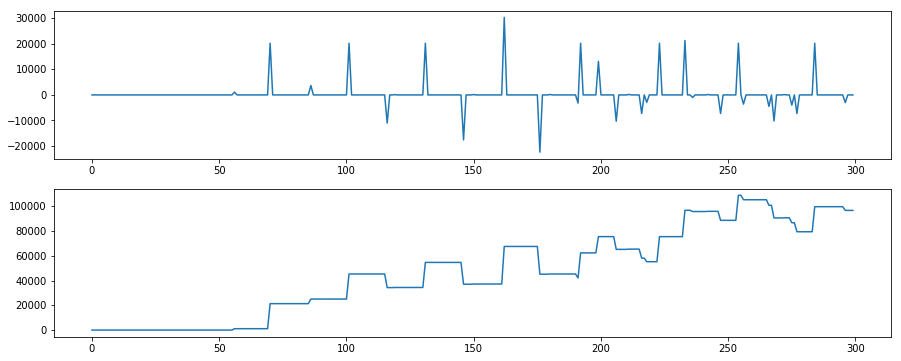

In [18]:
plt.subplots(2, 1, figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(transactions[1, :, 0][:300])
plt.subplot(2, 1, 2)
plt.plot(transactions[1, :, 1][:300])

In [19]:
transactions_min = np.min(transactions[:, :, 0])
transactions_max = np.max(transactions[:, :, 0])
transactions[:, :, 0] = 2 * ((transactions[:, :, 0] - transactions_min) / (transactions_max - transactions_min)) - 1

transactions_min = np.min(transactions[:, :, 1])
transactions_max = np.max(transactions[:, :, 1])
transactions[:, :, 1] = 2 * ((transactions[:, :, 1] - transactions_min) / (transactions_max - transactions_min)) - 1

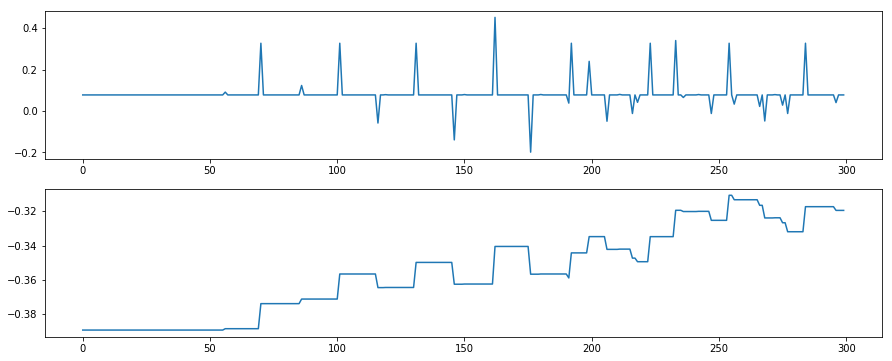

In [20]:
plt.subplots(2, 1, figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(transactions[1, :, 0][:300])
plt.subplot(2, 1, 2)
plt.plot(transactions[1, :, 1][:300])

In [21]:
np.save('usable/normalized_transactions_balances.npy', transactions)

## Splitted normalized transactions (100)

In [3]:
def split_data(dataset, timesteps):
    D = dataset.shape[1]
    if D < timesteps:
        return None
    elif D == timesteps:
        return dataset
    else:
        splitted_data, remaining_data = np.hsplit(dataset, [timesteps])
        remaining_data = split_data(remaining_data, timesteps)
        if remaining_data is not None:
            return np.vstack([splitted_data, remaining_data])
        return splitted_data

In [8]:
transactions = np.load('usable/normalized_transactions.npy')
transactions.shape

(4500, 2190)

In [9]:
timesteps = 100
transactions = split_data(transactions, timesteps)
transactions = transactions[np.std(transactions, 1) > float(1e-7)]
transactions.shape

(53888, 100)

In [10]:
np.save('usable/normalized_transactions_100.npy', transactions)

## Normalized transactions splitted by month

In [94]:
transactions = np.load('usable/normalized_transactions.npy')
transactions.shape

(4500, 2190)

In [95]:
d0 = date(1993, 1, 1)
d1 = date(1998, 12, 31)
new_transactions = np.zeros((4500, 30*12*6))

In [96]:
current_date = d0
current_month = 1
current_year = 1993
row_index = 0

while (d1 - current_date). days >= 0:
    if current_date.day <=30:
#         print(current_date)
        transaction_index = current_date.day - 1 
        transaction_index += (current_date.month-1) * 30 
        transaction_index += (current_date.year - 1993) * 360
        new_transactions[:, transaction_index] = transactions[:, (current_date - d0).days]
    if current_date.month != current_month:
        row_index +=1
        current_month += 1
        if current_month == 13:
            current_month == 1
    current_date += datetime.timedelta(days=1)
    
np.save('usable/normalized_transactions_months.npy', new_transactions)